In [247]:
import pandas as pd
import numpy as np
import os
from functools import reduce
from datetime import date,datetime
from dateutil.relativedelta import relativedelta as rd # *

from scipy.stats import ks_2samp

from sklearn.preprocessing import OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron,PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix # 1/2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV # *

import matplotlib.pyplot as plt
import seaborn as sns
import pygal # *

from sklearn.manifold import MDS,TSNE

import random
import timeit
from datetime import datetime
from time import time

pd.set_option('display.max_columns',1000)

# Análisis exploratorio de la población

## Muestreo

### Tamaño de la muestra

Se trabajara con una muestra por la imposibilidad de trabajar con la población completa a causa del hardware de la computadora, el tamaño de la muestra se calculará con las formulas de Cochran(1977).

Primero se toma una muestra preliminar de tamaño 30,000 para poder utilizar las formulas que Cochran plantea en su libro.

In [2]:
muestra = pd.read_csv('muestra')
muestra.drop('Unnamed: 0',axis=1,inplace=True)
muestra.head(2)

VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  passenger_count  \
0         1  09/22/2018 11:05:15 PM  09/22/2018 11:13:27 PM                1   
1         1  09/23/2018 12:00:15 AM  09/23/2018 12:15:44 AM                1   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            0.8           1                  N           246            48   
1            3.2           1                  N           113            97   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1          7.0    0.5      0.5        1.65           0.0   
1             1         13.5    0.5      0.5        3.70           0.0   

   improvement_surcharge  total_amount  
0                    0.3          9.95  
1                    0.3         18.50

Para simplificar el cálculo del tamaño de la muestra se tomaran en cuenta ciertas variables continuas, en especifico *passenger_count*, *trip_distance*, y *total_amount* de forma que se calculara el tamaño de la muestra
necesaria para que la **media muestral** sea igual que la **media poblacional** de cada una de estas variables y al final se elegirá el tamaño más grande que reporte cada cálculo como tamaño de la muestra que se tomará al final.

Para ello primero necesitamos algo de información de la muestra preliminar.

In [3]:
muestra[['passenger_count','trip_distance','total_amount']].describe()

passenger_count  trip_distance  total_amount
count     30000.000000   30000.000000  30000.000000
mean          1.592333       2.918774     16.260045
std           1.235257       3.746827     13.998754
min           0.000000       0.000000    -21.800000
25%           1.000000       0.950000      8.300000
50%           1.000000       1.600000     11.800000
75%           2.000000       3.000000     17.760000
max           7.000000      56.300000    260.800000

La formula para calcular el tamaño de la muestra necesita un valor $Z$ que es el valor de la distribución normal para cierto nivel de confianza, en este caso queremos un nivel de confiansa del 99% por lo que $Z=2.576$. $E$ es el error que se esta dispuesto a cometer, en este caso debido a la diferencia de unidades que hay en cada variable, pero será un error que no sobrepase una centesima parte del rango de observaciones de cada variable, aunque con *passenger_count* se será algo más exigente ya que en realidad es una variable que solo devuelve valores enteros, por lo que se buscara que su error sea de $1/500$ de acuerdo a su rango. Y finalmente la desviación estandar $s$ de cada variable.

In [1]:
def calcMuestra(Z,E,s):
    return ( (Z*s)/E )**2

In [6]:
E=1
s=70
Z=2.576
n5=calcMuestra(Z,E,s)
n5

32515.302399999997

In [5]:
muestra.passenger_count.std()**2

1.52585875084725

In [6]:
Z=2.576
# Para passenger counts
E=(7-0)/500
s=muestra.passenger_count.std()
n1=calcMuestra(Z,E,s)
# Para trip_distance
E=(56.3-0)/100
s=muestra.trip_distance.std()
n2=calcMuestra(Z,E,s)
#Para total_amount
E=260/100
s=muestra.total_amount.std()
n3=calcMuestra(Z,E,s)
print(n1,n2,n3)

51659.4738686845 293.90182905106946 192.36399546677478


Se puede notar que, en general, no se necesita una muestra nada grande para lograr estimar de buena manera las medias poblacionales de estas variables, y de hecho la unica que exige una muestra grande es la de *passenger_coun* debido a que se sido muy exigente con el error permitido, pero es algo que se puede permitir con tal de mejorar las estimaciones. 

Se dejará el tamaño de la muestra en $60,000$ para redondear y pensando en que no se han tomado todas las formalidades necesarias para calcluar el tamaño de la muestra para todas las variables y solo se ha hecho una simplificación, simplificación que dada la importancia que tendrán estas variables en los calculos siguientes es  apropiada y podemos tener la certeza de que una muestra aleatoria del tamaño dicho será representativa de la muestra.

### Obtener la muestra

La cantidad de tuplas que hay en el archivo es $n=112234626$, esto se consiguio con el contador de lineas de *bash*. Con ese número lo que se procede a hacer es una muestra aleatoria sin remplazo de **números** entre el $0$ y $n$ de forma que cada número representa a una tupla que será seleccionada.

Dado el tamaño de la población se puede asumir *pobación infinita* y simplificar calculos.

In [7]:
n = 112234626
n

112234626

In [8]:
tam = 60000 # Tamaño de la muestra 
list_muestra = sorted(random.sample(range(1,n+1),tam)) #El indice 0 del encabezado no se incluye
len(list_muestra)

60000

Una vez que se tiene la muestra de números se usará un parámetro de *pandas.read_csv* que permite "evitar" filas y no leerlas. Por lo que necesitamos una lista **skip** que sea el complemento de la lista **muestra** que tenemos para que solo lea las tuplas que corresponden a los números que estan en la lista **muestra**.

In [9]:
# Se implementó la función de busqueda binaria para agilizar el proceso
def binarySearch (arr, l, r, x): 
    while((r-l)>1):
        m=int((l+r)/2)
        if(arr[m]==x or arr[0]==x):
            return True
        if(arr[m]>x):
            r=m
        else:
            l=m
    return False

In [10]:
#Crear una lista de lineas que evite la funcion read_csv
skip=[]
k=len(list_muestra)
t=time()
for i in range(1,n+1):
    if( binarySearch(list_muestra,0,k,i) == False):
        skip.append(i)
    # Este apartado se creo para darle seguimiento al proceso mientras se hace
    if(time() > t+100):# Se muestra solo cada que han pasado alrededor de 2 minutos para no saturar de información
        print(i)
        print (datetime.now())
        t=time()
skip     

5348980
2021-01-02 11:48:24.146723
10696892
2021-01-02 11:50:04.147032
16059133
2021-01-02 11:51:44.147379
21432477
2021-01-02 11:53:24.147683
26818468
2021-01-02 11:55:04.147991
32180443
2021-01-02 11:56:44.148296
37531219
2021-01-02 11:58:24.148603
42891842
2021-01-02 12:00:04.148937
48246574
2021-01-02 12:01:44.149230
53588583
2021-01-02 12:03:24.149529
58951081
2021-01-02 12:05:04.192438
64312953
2021-01-02 12:06:44.192758
69645589
2021-01-02 12:08:24.238118
74909790
2021-01-02 12:10:04.278571
80252233
2021-01-02 12:11:44.278876
85612104
2021-01-02 12:13:24.279179
90965507
2021-01-02 12:15:04.279503
96315075
2021-01-02 12:16:44.279835
101689264
2021-01-02 12:18:24.280134
107026520
2021-01-02 12:20:04.280431


[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [15]:
df = pd.read_csv('nyc_taxi/2018_Yellow_Taxi_Trip_Data.csv', skiprows = skip)

Finalmente se envia a un archivo llamao *muestra.csv* para que se trabaje con ese archivo en el modelo.

In [16]:
df.to_csv("muestra.csv")

In [18]:
df.shape

(60000, 17)

In [17]:
df.head(2)

VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  passenger_count  \
0         2  09/22/2018 11:58:56 PM  09/23/2018 12:04:00 AM                1   
1         2  09/22/2018 11:47:40 PM  09/23/2018 12:18:37 AM                1   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.60           1                  N           234           107   
1          11.57           1                  N           163            28   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1          5.0    0.5      0.5        1.26           0.0   
1             1         35.5    0.5      0.5        9.20           0.0   

   improvement_surcharge  total_amount  
0                    0.3          7.56  
1                    0.3         46.00

# Lectura de datos

Se necesito hacer un muestreo aleatorio simple sin remplazo para poder trabajar con los datos, este se llevo a
cabo seleccionando pseudo-aleatoriamente numeros entre 1 y 112,234,626, que son la cantidad de entradas que
tienen los datos. Posterior a esto se hizo una lectura de los datos para unicamente 30,000 entradas.

In [199]:
df = pd.read_csv('muestra.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  passenger_count  \
0         2  09/22/2018 11:58:56 PM  09/23/2018 12:04:00 AM                1   
1         2  09/22/2018 11:47:40 PM  09/23/2018 12:18:37 AM                1   
2         2  09/22/2018 11:15:19 PM  09/22/2018 11:27:49 PM                1   
3         1  09/23/2018 12:27:41 AM  09/23/2018 12:45:42 AM                1   
4         2  09/23/2018 12:06:32 AM  09/23/2018 12:13:09 AM                1   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.60           1                  N           234           107   
1          11.57           1                  N           163            28   
2           1.28           1                  N           186           230   
3           5.30           1                  N           146           238   
4           1.35           1                  N           239           143   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1          5.0    0.5      0.5        1.26           0.0   
1             1         35.5    0.5      0.5        9.20           0.0   
2             2          9.5    0.5      0.5        0.00           0.0   
3             2         17.5    0.5      0.5        0.00           0.0   
4             1          7.0    0.5      0.5        1.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3          7.56  
1                    0.3         46.00  
2                    0.3         10.80  
3                    0.3         18.80  
4                    0.3          9.30

# Ingeniería de datos

## Tratamiento básico de los datos

In [220]:
#Definición de variables continuas que serán de útilidad más adelante
varc =['passenger_count', 'trip_distance', 'fare_amount',
       'extra', 'tip_amount','tax_surcharge_and_tolls']

In [214]:
# Fechas en formato manejable
df['tpep_pickup_datetime']=pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime']=pd.to_datetime(df['tpep_dropoff_datetime'])

### Valores fuera de rango

#### RatecodeID

Aquí se revisarán las calificaciones de *RatecodeID* que no correspondan a las categorias que maneja el diccionario de datos

In [215]:
categorias=[1,2,3,4,5,6]
df.loc[df['RatecodeID'].map(lambda x: x not in categorias)]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
4687         1  2018-10-24 22:03:12   2018-10-24 22:03:12                0   
4701         1  2018-10-25 00:07:29   2018-10-25 00:07:29                0   
5602         1  2018-10-31 02:35:37   2018-10-31 02:35:37                0   

      trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
4687            0.0          99                  Y           230   
4701            0.0          99                  Y           264   
5602            0.0          99                  Y           264   

      DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
4687           264             1        21.50    0.0      0.5         0.0   
4701           264             1         6.05    0.0      0.5         0.0   
5602           264             1         9.10    0.0      0.0         0.0   

      tolls_amount  improvement_surcharge  total_amount  
4687           0.0                    0.3         22.30  
4701           0.0                    0.3          6.85  
5602           0.0                    0.0          9.10

Como solo son 3 filas, un porcentaje pequeño comparado con el total, se eliminarán.

In [216]:
filas=list(df.loc[df['RatecodeID'].map(lambda x: x not in categorias)].index)
df.drop(filas,axis=0,inplace=True)

#### VendorID

In [210]:
categorias_v=[1,2]
df.loc[df['VendorID'].map(lambda x: x not in categorias_v)].tail()

VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  \
59659         4  09/20/2018 08:42:01 PM  09/20/2018 08:54:39 PM   
59678         4  09/20/2018 10:05:58 PM  09/20/2018 10:13:25 PM   
59778         4  09/21/2018 02:55:40 PM  09/21/2018 02:59:04 PM   
59790         4  09/21/2018 04:34:04 PM  09/21/2018 04:42:23 PM   
59851         4  09/22/2018 12:48:12 AM  09/22/2018 01:01:56 AM   

       passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
59659                1           1.90           1                  N   
59678                1           1.06           1                  N   
59778                1           0.62           1                  N   
59790                1           0.99           1                  N   
59851                1           2.20           1                  N   

       PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
59659           158           261             1         10.0    0.5      0.5   
59678           237           229             1          6.5    0.5      0.5   
59778            68            68             1          4.5    0.0      0.5   
59790           262           140             1          7.0    1.0      0.5   
59851           249           209             1         10.5    0.5      0.5   

       tip_amount  tolls_amount  improvement_surcharge  total_amount  
59659        2.26           0.0                    0.3         13.56  
59678        1.56           0.0                    0.3          9.36  
59778        1.06           0.0                    0.3          6.36  
59790        0.10           0.0                    0.3          8.90  
59851        2.95           0.0                    0.3         14.75

Como son muchas las categorías que están en los datos y no pertenecen a alguno de los dos grupos que menciona el diccionario de datos lo que se hará es repartir aleatoriamente en uno de los dos grupos

In [211]:
filas=list(df.loc[df['VendorID'].map(lambda x: x not in categorias)].index)
df.iloc[filas,0].value_counts()

4    281
Name: VendorID, dtype: int64

In [212]:
for i in filas:
    df.iloc[i,0]=random.randint(1,2)

In [213]:
df.loc[auxi['VendorID'].map(lambda x: x not in categorias)]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount]
Index: []

#### Fechas

Aquí se eliminan las tuplas que no pertenezcan al año 2018, pues no es de interes otro año.

In [221]:
año=2018
filas = list(df['tpep_pickup_datetime'].loc[df['tpep_pickup_datetime'].map(lambda x: x.year) != 2018].index)
filas.extend(list(df['tpep_dropoff_datetime'].loc[df['tpep_dropoff_datetime'].map(lambda x: x.year) != año].index))
df.drop(filas,axis=0,inplace=True)

In [8]:
df.shape

(59992, 17)

#### Resumir variables de dinero

In [9]:
df.describe()

VendorID  passenger_count  trip_distance    RatecodeID  \
count  59992.000000     59992.000000   59992.000000  59992.000000   
mean       1.592462         1.595029       2.900333      1.043556   
std        0.519191         1.241693       3.781728      0.306269   
min        1.000000         0.000000       0.000000      1.000000   
25%        1.000000         1.000000       0.950000      1.000000   
50%        2.000000         1.000000       1.600000      1.000000   
75%        2.000000         2.000000       2.980000      1.000000   
max        4.000000         7.000000     136.100000      5.000000   

       PULocationID  DOLocationID  payment_type   fare_amount         extra  \
count  59992.000000  59992.000000  59992.000000  59992.000000  59992.000000   
mean     163.149887    161.755684      1.313575     12.921052      0.332593   
std       66.620659     70.015167      0.484478     16.167362      0.466664   
min        1.000000      1.000000      1.000000    -63.500000     -4.500000   
25%      114.000000    113.000000      1.000000      6.500000      0.000000   
50%      162.000000    162.000000      1.000000      9.500000      0.000000   
75%      233.000000    234.000000      2.000000     14.500000      0.500000   
max      265.000000    265.000000      4.000000   2759.070000      4.500000   

            mta_tax    tip_amount  tolls_amount  improvement_surcharge  \
count  59992.000000  59992.000000  59992.000000           59992.000000   
mean       0.497358      1.861570      0.336360               0.299590   
std        0.039968      2.520522      1.533625               0.014996   
min       -0.500000      0.000000     -5.760000              -0.300000   
25%        0.500000      0.000000      0.000000               0.300000   
50%        0.500000      1.380000      0.000000               0.300000   
75%        0.500000      2.450000      0.000000               0.300000   
max        0.500000    101.100000     85.260000               0.300000   

       total_amount  
count  59992.000000  
mean      16.252053  
std       18.133469  
min      -64.300000  
25%        8.300000  
50%       11.760000  
75%       17.760000  
max     2759.370000

In [218]:
df['tax_surcharge_and_tolls']=df['mta_tax']+df['improvement_surcharge']+df['tolls_amount']

### Tratar negativos

Se eliminaran los datos negativos ya que no tiene sentido tener distancias negativas o tiempo negativo. No hay nada en los diccionario de datos que indique debemos considerar devoluciones, así que se eliminara también las cantidades de dinero negativas.

In [222]:
aux = df[varc].copy()
for var in list(aux.columns):
    filas = list(aux[[var]].loc[aux[var]<0].index)
    aux.drop(filas,axis=0,inplace=True)
df.shape[0]-aux.shape[0] # Datos eliminados

34

Como son pocos datos se procede a eliminarlos

In [223]:
df[varc] = aux.copy()
df.reset_index()
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2018-09-22 23:58:56   2018-09-23 00:04:00              1.0   
1         2  2018-09-22 23:47:40   2018-09-23 00:18:37              1.0   
2         2  2018-09-22 23:15:19   2018-09-22 23:27:49              1.0   
3         1  2018-09-23 00:27:41   2018-09-23 00:45:42              1.0   
4         2  2018-09-23 00:06:32   2018-09-23 00:13:09              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.60           1                  N           234           107   
1          11.57           1                  N           163            28   
2           1.28           1                  N           186           230   
3           5.30           1                  N           146           238   
4           1.35           1                  N           239           143   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1          5.0    0.5      0.5        1.26           0.0   
1             1         35.5    0.5      0.5        9.20           0.0   
2             2          9.5    0.5      0.5        0.00           0.0   
3             2         17.5    0.5      0.5        0.00           0.0   
4             1          7.0    0.5      0.5        1.00           0.0   

   improvement_surcharge  total_amount  tax_surcharge_and_tolls  
0                    0.3          7.56                      0.8  
1                    0.3         46.00                      0.8  
2                    0.3         10.80                      0.8  
3                    0.3         18.80                      0.8  
4                    0.3          9.30                      0.8

In [224]:
df.describe()

VendorID  passenger_count  trip_distance    RatecodeID  \
count  59992.000000      59958.00000   59958.000000  59992.000000   
mean       1.580677          1.59470       2.901066      1.043556   
std        0.493452          1.24129       3.780546      0.306269   
min        1.000000          0.00000       0.000000      1.000000   
25%        1.000000          1.00000       0.950000      1.000000   
50%        2.000000          1.00000       1.600000      1.000000   
75%        2.000000          2.00000       2.980000      1.000000   
max        2.000000          7.00000     136.100000      5.000000   

       PULocationID  DOLocationID  payment_type   fare_amount         extra  \
count  59992.000000  59992.000000  59992.000000  59958.000000  59958.000000   
mean     163.149887    161.755684      1.313575     12.935585      0.332998   
std       66.620659     70.015167      0.484478     16.153938      0.466109   
min        1.000000      1.000000      1.000000      0.000000      0.000000   
25%      114.000000    113.000000      1.000000      6.500000      0.000000   
50%      162.000000    162.000000      1.000000      9.500000      0.000000   
75%      233.000000    234.000000      2.000000     14.500000      0.500000   
max      265.000000    265.000000      4.000000   2759.070000      4.500000   

            mta_tax    tip_amount  tolls_amount  improvement_surcharge  \
count  59992.000000  59958.000000  59992.000000           59992.000000   
mean       0.497358      1.862626      0.336360               0.299590   
std        0.039968      2.520846      1.533625               0.014996   
min       -0.500000      0.000000     -5.760000              -0.300000   
25%        0.500000      0.000000      0.000000               0.300000   
50%        0.500000      1.400000      0.000000               0.300000   
75%        0.500000      2.450000      0.000000               0.300000   
max        0.500000    101.100000     85.260000               0.300000   

       total_amount  tax_surcharge_and_tolls  
count  59992.000000             59958.000000  
mean      16.252053                 1.134500  
std       18.133469                 1.523544  
min      -64.300000                 0.000000  
25%        8.300000                 0.800000  
50%       11.760000                 0.800000  
75%       17.760000                 0.800000  
max     2759.370000                86.060000

### Modificación del formato de las fechas

Ahora se usarán las fechas para obtener el "dia del año" y la "Hora de inicio" del viaje, que serán la unidad
muestral. Además de la "Duración en minutos" del viaje para así no perder información valiosa al no
tener como tal las fechas como variables continuas y se agrega "Trimestre" para poder manejar mejor la variabilidad de los datos más adelante.

In [225]:
temp=df['tpep_pickup_datetime']
aux=df['tpep_dropoff_datetime']
df['Dia_del_año']=temp.map(lambda x: x.dayofyear)
df['Hora_inicio']=temp.map(lambda x:x.hour)
df['Duración_minutos']=(aux-temp).map(lambda x:x.seconds/60)

In [226]:
# Es necesario rehacer lista de varc
varc =['Duración_minutos','passenger_count', 'trip_distance', 'fare_amount',
       'extra', 'tip_amount','tax_surcharge_and_tolls']

In [328]:
df.to_csv("df.csv",index=False)

## Transformación de los datos

In [16]:
vobs= 15
vdes= 1
vard=['VendorID','payment_type','RatecodeID']
diai,diaf=(1,365)
anclai = diai+vobs-1
anclaf = diaf-vdes
df['Viajes'] = 1
step=5
um =['Hora_inicio','ancla']
anclai,anclaf

(15, 364)

In [324]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2018-09-22 23:58:56   2018-09-23 00:04:00              1.0   
1         2  2018-09-22 23:47:40   2018-09-23 00:18:37              1.0   
2         2  2018-09-22 23:15:19   2018-09-22 23:27:49              1.0   
3         1  2018-09-23 00:27:41   2018-09-23 00:45:42              1.0   
4         2  2018-09-23 00:06:32   2018-09-23 00:13:09              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.60           1                  N           234           107   
1          11.57           1                  N           163            28   
2           1.28           1                  N           186           230   
3           5.30           1                  N           146           238   
4           1.35           1                  N           239           143   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1          5.0    0.5      0.5        1.26           0.0   
1             1         35.5    0.5      0.5        9.20           0.0   
2             2          9.5    0.5      0.5        0.00           0.0   
3             2         17.5    0.5      0.5        0.00           0.0   
4             1          7.0    0.5      0.5        1.00           0.0   

   improvement_surcharge  total_amount  tax_surcharge_and_tolls  Dia_del_año  \
0                    0.3          7.56                      0.8          265   
1                    0.3         46.00                      0.8          265   
2                    0.3         10.80                      0.8          265   
3                    0.3         18.80                      0.8          266   
4                    0.3          9.30                      0.8          266   

   Hora_inicio  Duración_minutos  
0           23          5.066667  
1           23         30.950000  
2           23         12.500000  
3            0         18.016667  
4            0          6.616667

### Variable predictora $X$

In [18]:
def trans(df,ancla,k):
    print(ancla,k)
    aux = df[varc].loc[(df['Dia_del_año']>=ancla-k+1) & (df['Dia_del_año']<=ancla) ]
    aux[um[0]]=df.loc[:,um[0]]
    
    def piv(aux,v,ancla):
        aux=df.pivot_table(index='Hora_inicio',
               columns=v,
                values=varc,
                aggfunc=['min','max','mean','sum','std']
                 )
        aux.columns = ["v_%s_"%v+"".join(str(x[2]))+"_"+"".join(x[1])+"_"+"".join(x[0])+"_%d"%k for x in aux.columns]
        aux.insert(0,'ancla',ancla)
        return aux.reset_index()
    aux = reduce( lambda x,y:pd.merge( x,y,on=um,how='inner' ), map(lambda v:piv(aux,v,ancla),vard) )
    return aux

In [19]:
X= pd.concat(map(lambda ancla : reduce( lambda x,y : pd.merge(x,y, on=um,how='inner'),
                                       map(lambda k:trans(df,ancla,k),
                                                              range(step,step+vobs,step) ) ),
                 range(anclai,anclaf+1) ),ignore_index=True )
X

15 5
15 10
15 15
16 5
16 10
16 15
17 5
17 10
17 15
18 5
18 10
18 15
19 5
19 10
19 15
20 5
20 10
20 15
21 5
21 10
21 15
22 5
22 10
22 15
23 5
23 10
23 15
24 5
24 10
24 15
25 5
25 10
25 15
26 5
26 10
26 15
27 5
27 10
27 15
28 5
28 10
28 15
29 5
29 10
29 15
30 5
30 10
30 15
31 5
31 10
31 15
32 5
32 10
32 15
33 5
33 10
33 15
34 5
34 10
34 15
35 5
35 10
35 15
36 5
36 10
36 15
37 5
37 10
37 15
38 5
38 10
38 15
39 5
39 10
39 15
40 5
40 10
40 15
41 5
41 10
41 15
42 5
42 10
42 15
43 5
43 10
43 15
44 5
44 10
44 15
45 5
45 10
45 15
46 5
46 10
46 15
47 5
47 10
47 15
48 5
48 10
48 15
49 5
49 10
49 15
50 5
50 10
50 15
51 5
51 10
51 15
52 5
52 10
52 15
53 5
53 10
53 15
54 5
54 10
54 15
55 5
55 10
55 15
56 5
56 10
56 15
57 5
57 10
57 15
58 5
58 10
58 15
59 5
59 10
59 15
60 5
60 10
60 15
61 5
61 10
61 15
62 5
62 10
62 15
63 5
63 10
63 15
64 5
64 10
64 15
65 5
65 10
65 15
66 5
66 10
66 15
67 5
67 10
67 15
68 5
68 10
68 15
69 5
69 10
69 15
70 5
70 10
70 15
71 5
71 10
71 15
72 5
72 10
72 15
73 5
73 10
73 

Hora_inicio  ancla  v_VendorID_1_Duración_minutos_min_5  \
0               0     15                             0.050000   
1               1     15                             0.000000   
2               2     15                             0.016667   
3               3     15                             0.000000   
4               4     15                             0.366667   
...           ...    ...                                  ...   
8395           19    364                             0.000000   
8396           20    364                             0.000000   
8397           21    364                             0.000000   
8398           22    364                             0.000000   
8399           23    364                             0.000000   

      v_VendorID_2_Duración_minutos_min_5  \
0                                0.050000   
1                                0.033333   
2                                0.033333   
3                                0.300000   
4                                0.050000   
...                                   ...   
8395                             0.033333   
8396                             0.050000   
8397                             0.050000   
8398                             0.033333   
8399                             0.066667   

      v_VendorID_4_Duración_minutos_min_5  v_VendorID_1_extra_min_5  \
0                                2.900000                       0.0   
1                                5.033333                       0.0   
2                                6.816667                       0.0   
3                                2.933333                       0.0   
4                                3.716667                       0.0   
...                                   ...                       ...   
8395                             0.166667                       0.0   
8396                             2.866667                       0.0   
8397                             0.050000                       0.0   
8398                             1.433333                       0.0   
8399                             2.116667                       0.0   

      v_VendorID_2_extra_min_5  v_VendorID_4_extra_min_5  \
0                          0.0                       0.5   
1                          0.0                       0.5   
2                          0.0                       0.5   
3                          0.0                       0.5   
4                          0.0                       0.0   
...                        ...                       ...   
8395                       0.0                       0.0   
8396                       0.0                       0.5   
8397                       0.0                       0.5   
8398                       0.0                       0.5   
8399                       0.0                       0.5   

      v_VendorID_1_fare_amount_min_5  v_VendorID_2_fare_amount_min_5  \
0                               0.01                             2.5   
1                               0.00                             2.5   
2                               2.50                             2.5   
3                               2.50                             2.5   
4                               3.50                             2.5   
...                              ...                             ...   
8395                            0.00                             2.5   
8396                            0.00                             2.5   
8397                            0.00                             2.5   
8398                            0.01                             2.5   
8399                            0.00                             0.0   

      v_VendorID_4_fare_amount_min_5  v_VendorID_1_passenger_count_min_5  \
0                                4.5                                 0.0   
1                                6.0                                 0.0   
2                

In [20]:
X.to_csv('X.csv') # Probar con la mediana en aggfun y quitar sum

### Variable a predecir $y$

El target $y$ muestra la cantidad de viajes promedio en el día $i$ a la hora $j$ durante los días de la ventana de observación, esto se calcula como la razón entre los viajes hechos en la hora $j$ dividido por los días que contempla la ventana de observación. 

In [21]:
def target(df,ancla):
    print(ancla)
    aux = df[varc].loc[(df['Dia_del_año']>=ancla-vobs+1) & (df['Dia_del_año']<=ancla) ]
    aux[um[0]]=df.loc[:,um[0]]
    aux=aux.assign(ancla=ancla)
    aux['Viajes']=df['Viajes'].copy()
    aux_gb=aux.groupby(um).Viajes.agg(['sum'])
    aux_gb.columns=['y']
    return aux_gb.div(vobs,level='y').reset_index()

In [22]:
def target_median(df,ancla,fun):
    print(ancla)
    datos = pd.DataFrame({ 'Hora_inicio':list(range(24)),'ancla':ancla })
    for i in range(vobs):
        aux = df[varc].loc[(df['Dia_del_año']==ancla-i)]
        aux[um[0]]=df.loc[:,um[0]]
        aux=aux.assign(ancla=ancla)
        aux['Viajes']=df['Viajes'].copy()
        aux_gb=aux.groupby(um).Viajes.agg(['sum'])
        aux_gb.columns=['y']
        datos=datos.merge(aux_gb,on=um,how='outer')
        aux=datos.T.iloc[2:].describe().T[[fun]]# Aquí se decide si será por media o mediana
        aux.insert(0,'ancla',ancla)
        aux.insert(0,um[0],list(aux.index))
        aux.columns=[um+['y']]
    return aux

In [23]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2018-09-22 23:58:56   2018-09-23 00:04:00              1.0   
1         2  2018-09-22 23:47:40   2018-09-23 00:18:37              1.0   
2         2  2018-09-22 23:15:19   2018-09-22 23:27:49              1.0   
3         1  2018-09-23 00:27:41   2018-09-23 00:45:42              1.0   
4         2  2018-09-23 00:06:32   2018-09-23 00:13:09              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.60           1                  N           234           107   
1          11.57           1                  N           163            28   
2           1.28           1                  N           186           230   
3           5.30           1                  N           146           238   
4           1.35           1                  N           239           143   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1          5.0    0.5      0.5        1.26           0.0   
1             1         35.5    0.5      0.5        9.20           0.0   
2             2          9.5    0.5      0.5        0.00           0.0   
3             2         17.5    0.5      0.5        0.00           0.0   
4             1          7.0    0.5      0.5        1.00           0.0   

   improvement_surcharge  total_amount  tax_surcharge_and_tolls  Dia_del_año  \
0                    0.3          7.56                      0.8          265   
1                    0.3         46.00                      0.8          265   
2                    0.3         10.80                      0.8          265   
3                    0.3         18.80                      0.8          266   
4                    0.3          9.30                      0.8          266   

   Hora_inicio  Duración_minutos  Viajes  
0           23          5.066667       1  
1           23         30.950000       1  
2           23         12.500000       1  
3            0         18.016667       1  
4            0          6.616667       1

In [24]:
anti= pd.concat(map(lambda ancla: target_median(df,ancla,'50%'), range(anclai,anclaf+1) ),ignore_index=True)
anti

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
2

Hora_inicio ancla    y
0              0    15  4.0
1              1    15  3.5
2              2    15  2.0
3              3    15  3.0
4              4    15  3.0
...          ...   ...  ...
8395          19   364  8.0
8396          20   364  5.0
8397          21   364  6.0
8398          22   364  6.0
8399          23   364  4.5

[8400 rows x 3 columns]

In [25]:
anti2= pd.concat(map(lambda ancla: target_median(df,ancla,'mean'), range(anclai,anclaf+1) ),ignore_index=True)
anti2

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
2

Hora_inicio ancla         y
0              0    15  4.769231
1              1    15  5.428571
2              2    15  2.538462
3              3    15  4.000000
4              4    15  3.000000
...          ...   ...       ...
8395          19   364  7.866667
8396          20   364  6.200000
8397          21   364  7.000000
8398          22   364  6.466667
8399          23   364  5.142857

[8400 rows x 3 columns]

In [26]:
y= pd.concat(map(lambda ancla: target(df,ancla), range(anclai,anclaf+1) ),ignore_index=True)
y

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
2

Hora_inicio  ancla         y
0               0     15  4.133333
1               1     15  5.066667
2               2     15  2.200000
3               3     15  2.133333
4               4     15  1.400000
...           ...    ...       ...
8395           19    364  7.866667
8396           20    364  6.200000
8397           21    364  7.000000
8398           22    364  6.466667
8399           23    364  4.800000

[8400 rows x 3 columns]

In [27]:
anti.to_csv("anti.csv")
anti2.to_csv("anti2.csv")

### Creación de TAD

In [28]:
tad=X.merge(y,on=um,how="inner")
tad.head()

Hora_inicio  ancla  v_VendorID_1_Duración_minutos_min_5  \
0            0     15                             0.050000   
1            1     15                             0.000000   
2            2     15                             0.016667   
3            3     15                             0.000000   
4            4     15                             0.366667   

   v_VendorID_2_Duración_minutos_min_5  v_VendorID_4_Duración_minutos_min_5  \
0                             0.050000                             2.900000   
1                             0.033333                             5.033333   
2                             0.033333                             6.816667   
3                             0.300000                             2.933333   
4                             0.050000                             3.716667   

   v_VendorID_1_extra_min_5  v_VendorID_2_extra_min_5  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   v_VendorID_4_extra_min_5  v_VendorID_1_fare_amount_min_5  \
0                       0.5                            0.01   
1                       0.5                            0.00   
2                       0.5                            2.50   
3                       0.5                            2.50   
4                       0.0                            3.50   

   v_VendorID_2_fare_amount_min_5  v_VendorID_4_fare_amount_min_5  \
0                             2.5                             4.5   
1                             2.5                             6.0   
2                             2.5                             7.0   
3                             2.5                             4.5   
4                             2.5                             4.5   

   v_VendorID_1_passenger_count_min_5  v_VendorID_2_passenger_count_min_5  \
0                                 0.0                                 1.0   
1                                 0.0                                 1.0   
2                                 0.0                                 1.0   
3                                 0.0                                 1.0   
4                                 0.0                                 1.0   

   v_VendorID_4_passenger_count_min_5  \
0                                 1.0   
1                                 1.0   
2                                 1.0   
3                                 1.0   
4                                 1.0   

   v_VendorID_1_tax_surcharge_and_tolls_min_5  \
0                                         0.3   
1                                         0.3   
2                                         0.3   
3                                         0.3   
4                                         0.3   

   v_VendorID_2_tax_surcharge_and_tolls_min_5  \
0                                         0.3   
1                                         0.3   
2                                         0.8   
3                                         0.3   
4                                         0.8   

   v_VendorID_4_tax_surcharge_and_tolls_min_5  v_VendorID_1_tip_amount_min_5  \
0                                         0.8                            0.0   
1                                         0.8                            0.0   
2                                         0.8                            0.0   
3                                         0.8                            0.0   
4                                         0.8                            0.0   

   v_VendorID_2_tip_amount_min_5  v_VendorID_4_tip_amount_min_5  \
0                            0.0                           0.00   
1                            0.0                           0.00   
2                            0.0    

In [29]:
tad.to_csv('tad.csv')

# Análisis exploratorio de la TAD

## Valores ausentes

In [30]:
varc = [v for v in tad.columns if v[:2]=='v_']
tgt = 'y'
len(varc)

1260

In [31]:
miss = 1-tad[varc].describe().T[['count']]/len(tad)

In [32]:
miss.describe(percentiles=[0.1,0.75,0.80,0.85,0.90,0.95,0.98,0.99])

count
count  1260.000000
mean      0.044841
std       0.103102
min       0.000000
10%       0.000000
50%       0.000000
75%       0.000000
80%       0.041667
85%       0.125000
90%       0.250000
95%       0.250000
98%       0.291667
99%       0.541667
max       0.541667

A las columnas que superen el umbral dado por el percentil 99 en cuando a datos ausentes se les eliminará, debido a que la mayor parte de su información son datos ausentes. Con el resto se llevará a cabo un proceso de imputación

In [33]:
p = float(miss.describe(percentiles=[0.1,0.75,0.78,0.79,0.80,0.85,0.86,0.90,0.95,0.99]).loc['99%'])
p

0.5416666666666667

In [34]:
columnas=list(miss.loc[miss['count']>=p].index)
tad.drop(columnas,axis=1,inplace=True)
len(tad.columns)

1242

Como se eliminaron las columnas es necesario llenar de nuevo la lista de variables continuas y correr de nuevo el script para contar los valores ausentes.

In [35]:
varc=[v for v in tad.columns if v[:2]=='v_']

In [36]:
miss = 1-tad[varc].describe().T[['count']]/len(tad)

In [37]:
miss.describe(percentiles=[0.80,0.85,0.90,0.95,0.99])

count
count  1239.000000
mean      0.036421
std       0.080946
min       0.000000
50%       0.000000
80%       0.041667
85%       0.125000
90%       0.250000
95%       0.250000
99%       0.291667
max       0.291667

Notamos que hay aún alrededor del 20% de las columnas con valores ausentes, pero estos ya no son mayoria en dichas columnas, por eso se hará la imputación como se dijo antes.

In [38]:
X = tad[varc]

In [39]:
im = SimpleImputer(strategy='median')

In [40]:
im.fit(X)

SimpleImputer(strategy='median')

In [41]:
Xi = pd.DataFrame(im.transform(X),columns=varc)

Ahora se hace una prueba de bondad de ajuste para verificar que X con datos imputas es estadísticamente igual a la original

In [42]:
ks = pd.DataFrame(map(lambda v: (v,ks_2samp(tad[v].dropna(),Xi[v]).statistic),varc),columns=['variable','ks'])

In [43]:
ks.loc[ks['ks']>.1]

variable        ks
220         v_payment_type_4_Duración_minutos_std_5  0.125000
228              v_payment_type_4_fare_amount_std_5  0.125000
244            v_payment_type_4_trip_distance_std_5  0.125000
248           v_RatecodeID_4_Duración_minutos_min_5  0.125000
253                      v_RatecodeID_4_extra_min_5  0.125000
...                                             ...       ...
1221              v_RatecodeID_3_fare_amount_std_15  0.137255
1225          v_RatecodeID_3_passenger_count_std_15  0.137255
1229  v_RatecodeID_3_tax_surcharge_and_tolls_std_15  0.137255
1233               v_RatecodeID_3_tip_amount_std_15  0.137255
1237            v_RatecodeID_3_trip_distance_std_15  0.137255

[96 rows x 2 columns]

Aunque 96 son muchas columnas a eliminar aún queda más del 90% de las columnas y además parece que hacen más daño al modelo si no las quitamos.

In [44]:
Xi_sin=Xi.copy()
columnas=list(ks.loc[ks['ks']>.1]['variable'])
Xi_sin.drop(columnas,axis=1,inplace=True)

varc2 = [v for v in Xi_sin.columns if v[:2]=='v_'] # Es necesario actualizar la lista
Xi_sin.shape

(8400, 1143)

Verificamos que todo haya salido bien.

In [45]:
miss = 1-Xi_sin.describe().T[['count']]/len(Xi)
miss.describe()

count
count  1143.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0

## Extremos

In [47]:
ol = X.describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist()

aux = X.copy()
suma=0
for v,li,ls in ol:
    filas = list(aux[[v]].loc[aux[v] < li ].index)
    filas.extend( list(aux[[v]].loc[aux[v] > ls ].index) )
    suma = suma + len(filas)
    if len(filas) != 0:
        print(v,li,ls)
        print("Cantidad de filas eliminadas =",len(filas))
        print("\n")
    aux.drop(filas,axis=0,inplace = True)
print( "Eliminaciones totales = ", suma)

v_VendorID_2_extra_std_5 0.0 0.8835536615959634
Cantidad de filas eliminadas = 350


Eliminaciones totales =  350


Como hay demasiados outliers en una sola columna será mejor eliminar esa columna

In [98]:
Xi_sin.drop('v_VendorID_2_extra_std_5',axis=1,inplace=True)
varc2.remove('v_VendorID_2_extra_std_5')
Xi_sin.shape

(8400, 1142)

In [49]:
Xi.drop('v_VendorID_2_extra_std_5',axis=1,inplace=True)
varc2.remove('v_VendorID_2_extra_std_5')
Xi.shape

(8400, 1238)

In [50]:
Xi_sin.to_csv("Xi_sin.csv")
Xi.to_csv("Xi.csv")

# Modelo

## Recuperación

In [95]:
#Xi=pd.read_csv('Xi.csv',index_col=False)
#Xi.drop('Unnamed: 0',axis=1,inplace=True)
#Xi_sin=pd.read_csv('Xi_sin.csv')
#Xi_sin.drop('Unnamed: 0',axis=1,inplace=True)
#tad=pd.read_csv('tad.csv')
#tad.drop('Unnamed: 0',axis=1,inplace=True)
anti2=pd.read_csv('anti2.csv')
anti2.drop('Unnamed: 0',axis=1,inplace=True)
anti2.head()

Hora_inicio  ancla         y
0            0     15  4.769231
1            1     15  5.428571
2            2     15  2.538462
3            3     15  4.000000
4            4     15  3.000000

In [96]:
y_anti=anti2[['y']]
y_anti

y
0     4.769231
1     5.428571
2     2.538462
3     4.000000
4     3.000000
...        ...
8395  7.866667
8396  6.200000
8397  7.000000
8398  6.466667
8399  5.142857

[8400 rows x 1 columns]

In [4]:
varc = [v for v in Xi_sin.columns if v[:2]=='v_']
tgt='y'
len(varc)

1142

In [5]:
tad[varc] = Xi_sin.copy()

---------- Fin -----------

-----------------------------------

## Volumen de viajes por hora

### Regresión lineal

In [81]:
y = tad[tgt].copy()

In [97]:
y=y_anti['y']
y

0       4.769231
1       5.428571
2       2.538462
3       4.000000
4       3.000000
          ...   
8395    7.866667
8396    6.200000
8397    7.000000
8398    6.466667
8399    5.142857
Name: y, Length: 8400, dtype: float64

In [98]:
Xt,Xv,yt,yv = train_test_split(Xi_sin,y,train_size=0.7)

In [87]:
modelo = LinearRegression()

In [99]:
hiperparametros=dict(fit_intercept=[True,False],normalize=[True,False])
hiperparametros

{'fit_intercept': [True, False], 'normalize': [True, False]}

In [100]:
grid = GridSearchCV(param_grid=hiperparametros,
                    estimator=modelo,
                    cv=10,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1,
                    verbose=True)

In [101]:
grid.fit(Xt,yt)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 63.0min finished


GridSearchCV(cv=10, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_absolute_error', verbose=True)

In [102]:
grid.best_params_

{'fit_intercept': True, 'normalize': False}

In [58]:
# Ya con 
grid.best_estimator_

LinearRegression()

In [103]:
modelo = grid.best_estimator_

In [104]:
grid.best_params_

{'fit_intercept': True, 'normalize': False}

In [108]:
modelo.fit(Xt,yt)

LinearRegression()

In [107]:
print(mean_absolute_error(y_true=yt,y_pred=modelo.predict(Xt)))
print(mean_absolute_error(y_true=yv,y_pred=modelo.predict(Xv)))

1.30055604620035
1.3068810938019646


/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='y', ylabel='Density'>

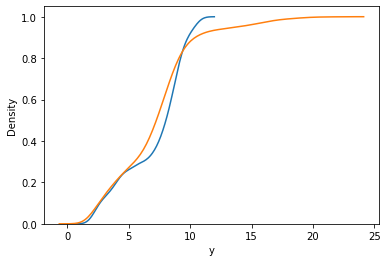

In [109]:
sns.distplot(modelo.predict(Xt),hist=False,kde_kws={'cumulative':True})
sns.distplot(yt,hist=False,kde_kws={'cumulative':True})

/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='y', ylabel='Density'>

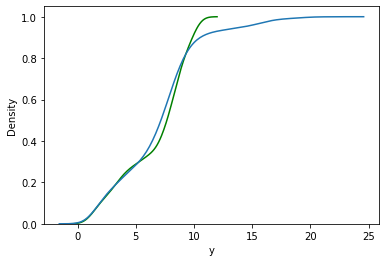

In [80]:
sns.distplot(modelo.predict(Xv),hist=False,kde_kws={'cumulative':True},color='green')
sns.distplot(yv,hist=False,kde_kws={'cumulative':True})

In [89]:
pd.Series(modelo.predict(Xt).tolist()).describe()

count    5880.000000
mean        6.895575
std         2.826608
min         1.492401
25%         3.980637
50%         7.907608
75%         8.845474
max        10.457092
dtype: float64

In [19]:
yt.describe(percentiles=[0.85,0.90,0.95,0.97,0.98,0.99])

count    5880.000000
mean        6.918923
std         3.529327
min         0.733333
50%         7.266667
85%         9.400000
90%        10.266667
95%        13.800000
97%        15.600000
98%        16.400000
99%        17.666667
max        22.333333
Name: y, dtype: float64

Notamos que el modelo redice bastante bien hasta cierto valor, a partir de ese valor deja de predecir, lo cual es entendible si vemos la tabla de percentiles de $y$ que muestra que solo el 10% sobrepasan la cantidad de 10 pasajeros por hora, el cual es el valor máximo que reportan las predicciones. Esto presenta un problema, pues si bien podemos decir que el 10% es una cantidad baja no podemos decir que es una cantidad despreciable.

Para resolver esto y pensando que solo es el $10%$ de la muestra la que va más allá del poder predictivo usaremos un modelo de clasificación para separar aquellos días que reciban 11 viajes o menos y los que reciban más que eso. Esto es razonable puesto que si bien el máximo de viajes llega a ser hasta de 22, el incremento se da en una pequeña parte de la muestra, así que podríamos decir que son horas atípicas en las que hay que estar preparado para recibir más de 10 viajes.

Ahora el problema que nos trajo a este modelo de clasificación es el **desbalanceo** de en los datos, el cual se podría "resolver" y mejorar las predicciones con un sub-muestreo pero es costoso y posiblemente afecte los buenos resultados que ya tenemos para las horas que reportan 10 viajes o menos. Por lo que un mejor acercamiento podría ser ayudarnos con un modelo de clasificación como la **regresión logística** que nos permite añadiendo un solo parámetro *class_weight='balanced'* "arreglar" el desbalanceo de los datos originales, eso si, el costo será tener falsos positivos(tomando positivo cuando *y* reporta un valor mayor a 10). Por ello nos ayudaremos con la regresión lineal y la logística para sacar conclusiones.

### Clasificación

Vamos a crear las variables necesarias para el modelo de clasificación

In [50]:
limite=10
y_binaria=[]
for i in y:
    if i>limite:
        y_binaria.append(1)
    else:
        y_binaria.append(0)

In [51]:
# Podemos hacer esta inserción simple pues el orden se preserva
tad_clas = Xi_sin.copy()
tad_clas.insert(1142,'y',y_binaria)
tad_clas.head()

v_VendorID_1_Duración_minutos_min_5  v_VendorID_2_Duración_minutos_min_5  \
0                             0.050000                             0.050000   
1                             0.000000                             0.033333   
2                             0.016667                             0.033333   
3                             0.000000                             0.300000   
4                             0.366667                             0.050000   

   v_VendorID_4_Duración_minutos_min_5  v_VendorID_1_extra_min_5  \
0                             2.900000                       0.0   
1                             5.033333                       0.0   
2                             6.816667                       0.0   
3                             2.933333                       0.0   
4                             3.716667                       0.0   

   v_VendorID_2_extra_min_5  v_VendorID_4_extra_min_5  \
0                       0.0                       0.5   
1                       0.0                       0.5   
2                       0.0                       0.5   
3                       0.0                       0.5   
4                       0.0                       0.0   

   v_VendorID_1_fare_amount_min_5  v_VendorID_2_fare_amount_min_5  \
0                            0.01                             2.5   
1                            0.00                             2.5   
2                            2.50                             2.5   
3                            2.50                             2.5   
4                            3.50                             2.5   

   v_VendorID_4_fare_amount_min_5  v_VendorID_1_passenger_count_min_5  \
0                             4.5                                 0.0   
1                             6.0                                 0.0   
2                             7.0                                 0.0   
3                             4.5                                 0.0   
4                             4.5                                 0.0   

   v_VendorID_2_passenger_count_min_5  v_VendorID_4_passenger_count_min_5  \
0                                 1.0                                 1.0   
1                                 1.0                                 1.0   
2                                 1.0                                 1.0   
3                                 1.0                                 1.0   
4                                 1.0                                 1.0   

   v_VendorID_1_tax_surcharge_and_tolls_min_5  \
0                                         0.3   
1                                         0.3   
2                                         0.3   
3                                         0.3   
4                                         0.3   

   v_VendorID_2_tax_surcharge_and_tolls_min_5  \
0                                         0.3   
1                                         0.3   
2                                         0.8   
3                                         0.3   
4                                         0.8   

   v_VendorID_4_tax_surcharge_and_tolls_min_5  v_VendorID_1_tip_amount_min_5  \
0                                         0.8                            0.0   
1                                         0.8                            0.0   
2                                         0.8                            0.0   
3                                         0.8                            0.0   
4                                         0.8                            0.0   

   v_VendorID_2_tip_amount_min_5  v_VendorID_4_tip_amount_min_5  \
0                            0.0                           0.00   
1                            0.0                           0.00   
2                            0.0                           0.00   
3                            0.0                           1.16   
4                            0.0                     

In [39]:
X=Xi_sin.copy()

In [60]:
from sklearn.linear_model import LogisticRegression
from scikitplot.metrics import plot_ks_statistic,plot_roc_curve

In [52]:
y=tad_clas[tgt]
X=Xi_sin.copy()

In [53]:
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7)

In [65]:
clasif = LogisticRegression(max_iter=10000,class_weight='balanced')

In [66]:
clasif.fit(Xt,yt)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [67]:
print(accuracy_score(y_pred=clasif.predict(Xt),y_true=yt))
print(accuracy_score(y_pred=clasif.predict(Xv),y_true=yv))

0.6336734693877552
0.6293650793650793


El accuracy score no es muy bueno, pero la curva *roc* es aceptable. Esto era de esperarse pues predice peor que si no tuviera el hiperparametro de *balanceo* activo, pero a cambio nos ofrece predicciones correctas para los positivos es por eso que la curva roc es aceptable y podemos decir que es un modelo aceptable.

In [68]:
print(roc_auc_score(y_score=clasif.predict_proba(Xt)[:,1],y_true=yt))
print(roc_auc_score(y_score=clasif.predict_proba(Xv)[:,1],y_true=yv))

0.7637875242056829
0.7526900182223122


In [69]:
print(confusion_matrix(y_true=yt,y_pred=clasif.predict(Xt)))
print(confusion_matrix(y_true=yv,y_pred=clasif.predict(Xv)))

[[3251 1988]
 [ 166  475]]
[[1397  848]
 [  86  189]]


La matriz de confusión ratifica lo que dijimos, tenemos muchos falsos positivos, pero a cambio tenemos predicciones para los positivos.

/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/home/oszwaldo/Documentos/Projects/env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

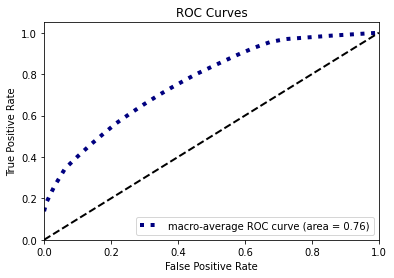

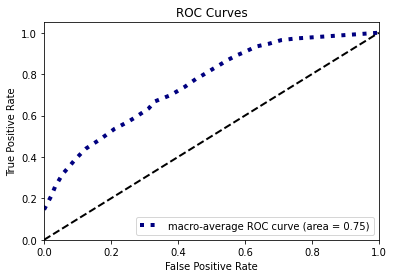

In [62]:
plot_roc_curve(y_true=yt,y_probas=clasif.predict_proba(Xt),curves='macro')
plot_roc_curve(y_true=yv,y_probas=clasif.predict_proba(Xv),curves='macro')

La curva roc muestra un buen comportamiento en la gráfica ya que ahora si se tiene un buena cantidad de valores positivos predichos.

Ahora, tenemos que dos modelos que deben trabajar en conjunto para dar buenas predicciones. El de clasificación nos dirá si la hora debe ser considerada de "alta demanda", i.e., más de 10 viajes en esa hora ocurrirán y con la regresión lineal veremos la cantidad de viajes que ocurrirán en esa hora. Habrá que tener cuidado con esto, por que nos veremos en situaciones buenas donde la clasificación nos diga que que es una hora de alta demanda y en efecto lo sea y otras en las que no. Lo podemos hacer para mitigar esto es analizar los resultados, si la clasificación dice que es de alta demanda y la predicción dice que habrá dos viajes pues parece poco fiable creerle a la clasificación, pero si en cambio la predicción dice que habrá 9 o 10 viajes y la clasificación dice que será de alta demanda se puede darle más fiabilidad a la clasificación. Un caso tal vez más complicado sería la situación en que la clasificación diga que no será de alta demanda y la predicción diga que habrá 8 o 9 viajes, en estos caso habría que ser precavidos y pensar que tal vez es un falso negativo.

Como se puede observar el usar estos dos modelos para sacar conclusiones nos dará más información al momento de decidir, aunque no por eso se vuelve más sencillo. Pero podremos estar más seguros al momento de hacer predicciones.

In [327]:
help(df.to_csv)

Help on method to_csv in module pandas.core.generic:

to_csv(path_or_buf: Union[str, pathlib.Path, IO[~AnyStr], NoneType] = None, sep: str = ',', na_rep: str = '', float_format: Union[str, NoneType] = None, columns: Union[Sequence[Union[Hashable, NoneType]], NoneType] = None, header: Union[bool, List[str]] = True, index: bool = True, index_label: Union[bool, str, Sequence[Union[Hashable, NoneType]], NoneType] = None, mode: str = 'w', encoding: Union[str, NoneType] = None, compression: Union[str, Mapping[str, str], NoneType] = 'infer', quoting: Union[int, NoneType] = None, quotechar: str = '"', line_terminator: Union[str, NoneType] = None, chunksize: Union[int, NoneType] = None, date_format: Union[str, NoneType] = None, doublequote: bool = True, escapechar: Union[str, NoneType] = None, decimal: Union[str, NoneType] = '.', errors: str = 'strict') -> Union[str, NoneType] method of pandas.core.frame.DataFrame instance
    Write object to a comma-separated values (csv) file.
    
    .. ver